In [1]:
# import system libs 
import os
import time
import shutil
import itertools

# import data handling tools 
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras import regularizers
from tensorflow.keras.metrics import categorical_crossentropy

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')


2024-05-03 20:46:20.555138: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-03 20:46:20.555196: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-03 20:46:20.556654: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


modules loaded


In [2]:
data_dir = '/kaggle/input/skin-cancer-mnist-ham10000/hmnist_28_28_RGB.csv'
data = pd.read_csv(data_dir)
data.head()

,pixel0000,pixel0001,pixel0002,pixel0003,pixel0004,pixel0005,pixel0006,pixel0007,pixel0008,pixel0009,...,pixel2343,pixel2344,pixel2345,pixel2346,pixel2347,pixel2348,pixel2349,pixel2350,pixel2351,label
0,192,153,193,195,155,192,197,154,185,202,...,173,124,138,183,147,166,185,154,177,2
1,25,14,30,68,48,75,123,93,126,158,...,60,39,55,25,14,28,25,14,27,2
2,192,138,153,200,145,163,201,142,160,206,...,167,129,143,159,124,142,136,104,117,2
3,38,19,30,95,59,72,143,103,119,171,...,44,26,36,25,12,17,25,12,15,2
4,158,113,139,194,144,174,215,162,191,225,...,209,166,185,172,135,149,109,78,92,2


In [3]:
Label = data["label"]
Data = data.drop(columns=["label"])

In [4]:
data["label"].value_counts()

label
4    6705
6    1113
2    1099
1     514
0     327
5     142
3     115
Name: count, dtype: int64

We have imbalance in the data

**Handling imbalanced datasets**

In [5]:
from imblearn.over_sampling import RandomOverSampler 

oversample = RandomOverSampler()
Data, Label  = oversample.fit_resample(Data, Label)
Data = np.array(Data).reshape(-1, 28, 28, 3)
print('Shape of Data :', Data.shape)

Shape of Data : (46935, 28, 28, 3)


In [6]:
Label = np.array(Label)
Label

array([2, 2, 2, ..., 6, 6, 6])

In [7]:
classes = {4: ('nv', ' melanocytic nevi'),
           6: ('mel', 'melanoma'),
           2 :('bkl', 'benign keratosis-like lesions'), 
           1:('bcc' , ' basal cell carcinoma'),
           5: ('vasc', ' pyogenic granulomas and hemorrhage'),
           0: ('akiec', 'Actinic keratoses and intraepithelial carcinomae'),
           3: ('df', 'dermatofibroma')}

In [8]:
from sklearn.model_selection import train_test_split

X_train , X_test , y_train , y_test = train_test_split(Data , Label , test_size = 0.25 , random_state = 49)

In [9]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(35201, 28, 28, 3)
(35201,)
(11734, 28, 28, 3)
(11734,)


**Convert labels to categorical types**

In [10]:
from tensorflow.keras.utils import to_categorical


In [11]:


y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

**Create Image Data Generation**

In [12]:
datagen = ImageDataGenerator(rescale=(1./255)
                             ,rotation_range=10
                             ,zoom_range = 0.1
                             ,width_shift_range=0.1
                             ,height_shift_range=0.1)

testgen = ImageDataGenerator(rescale=(1./255))

**Create ReduceLROnPlateau to learning rate reduction**

In [13]:
from keras.callbacks import ReduceLROnPlateau

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy'
                                            , patience = 2
                                            , verbose=1
                                            ,factor=0.5
                                            , min_lr=0.00001)

In [14]:
model = keras.models.Sequential()

# Create Model Structure
model.add(keras.layers.Input(shape=[28, 28, 3]))
model.add(keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'))
model.add(keras.layers.MaxPooling2D())
model.add(keras.layers.BatchNormalization())

model.add(keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'))
model.add(keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'))
model.add(keras.layers.MaxPooling2D())
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'))
model.add(keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'))
model.add(keras.layers.MaxPooling2D())
model.add(keras.layers.BatchNormalization())

model.add(keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'))
model.add(keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'))
model.add(keras.layers.MaxPooling2D())

model.add(keras.layers.Flatten())
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.Dense(units=256, activation='relu', kernel_initializer='he_normal'))
model.add(keras.layers.BatchNormalization())

model.add(keras.layers.Dense(units=128, activation='relu', kernel_initializer='he_normal'))
model.add(keras.layers.BatchNormalization())

model.add(keras.layers.Dense(units=64, activation='relu', kernel_initializer='he_normal'))
model.add(keras.layers.BatchNormalization())

model.add(keras.layers.Dense(units=32, activation='relu', kernel_initializer='he_normal', kernel_regularizer=keras.regularizers.L1L2()))
model.add(keras.layers.BatchNormalization())

model.add(keras.layers.Dense(units=7, activation='softmax', kernel_initializer='glorot_uniform', name='classifier'))
model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 32)        0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 14, 14, 32)        128       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 conv2d_2 (Conv2D)           (None, 14, 14, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 7, 7, 64)          0

**Training model**

In [15]:
history = model.fit(X_train ,
                    y_train ,
                    epochs=25 ,
                    batch_size=128,
                    validation_data=(X_test , y_test) ,
                    callbacks=[learning_rate_reduction])

Epoch 1/25


I0000 00:00:1714769199.018138    2036 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


276/276 [==============================] - 14s 18ms/step - loss: 1.1738 - accuracy: 0.5750 - val_loss: 0.8482 - val_accuracy: 0.6915 - lr: 0.0010
Epoch 2/25
276/276 [==============================] - 3s 13ms/step - loss: 0.5001 - accuracy: 0.8312 - val_loss: 0.3754 - val_accuracy: 0.8717 - lr: 0.0010
Epoch 3/25
276/276 [==============================] - 4s 13ms/step - loss: 0.2946 - accuracy: 0.9010 - val_loss: 0.3207 - val_accuracy: 0.8928 - lr: 0.0010
Epoch 4/25
276/276 [==============================] - 3s 13ms/step - loss: 0.2032 - accuracy: 0.9318 - val_loss: 0.2466 - val_accuracy: 0.9136 - lr: 0.0010
Epoch 5/25
276/276 [==============================] - 3s 13ms/step - loss: 0.1362 - accuracy: 0.9542 - val_loss: 0.2206 - val_accuracy: 0.9320 - lr: 0.0010
Epoch 6/25
276/276 [==============================] - 3s 13ms/step - loss: 0.1074 - accuracy: 0.9644 - val_loss: 0.1912 - val_accuracy: 0.9359 - lr: 0.0010
Epoch 7/25
276/276 [==============================] - 3s 12ms/step - loss:

**Show training history**

In [16]:
from tensorflow import keras
# Define or load your CNN model
cnn_model = keras.models.Sequential()
# Add layers and configure the model as needed

In [17]:
import joblib

In [18]:
joblib.dump(cnn_model, 'cnn_model_skin.joblib')

['cnn_model_skin.joblib']

In [19]:
from sklearn.ensemble import RandomForestClassifier

In [20]:
loaded_cnn_model = joblib.load('cnn_model_skin.joblib')

In [21]:
X_train_features = loaded_cnn_model.predict(X_train)
X_test_features = loaded_cnn_model.predict(X_test)

367/367 [==============================] - 1s 2ms/step


In [22]:
X_train_features_flat = X_train_features.reshape(X_train_features.shape[0], -1)
X_test_features_flat = X_test_features.reshape(X_test_features.shape[0], -1)

In [23]:
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=0)
rf_classifier.fit(X_train_features_flat, y_train)

RandomForestClassifier(random_state=0)

In [24]:
# Make predictions using the trained Random Forest classifier
y_pred = rf_classifier.predict(X_test_features_flat)

In [25]:
def plot_training(hist):
    tr_acc = hist.history['accuracy']
    tr_loss = hist.history['loss']
    val_acc = hist.history['val_accuracy']
    val_loss = hist.history['val_loss']
    index_loss = np.argmin(val_loss)
    val_lowest = val_loss[index_loss]
    index_acc = np.argmax(val_acc)
    acc_highest = val_acc[index_acc]

    plt.figure(figsize= (20, 8))
    plt.style.use('fivethirtyeight')
    Epochs = [i+1 for i in range(len(tr_acc))]
    loss_label = f'best epoch= {str(index_loss + 1)}'
    acc_label = f'best epoch= {str(index_acc + 1)}'
    
    plt.subplot(1, 2, 1)
    plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
    plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
    plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
    plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout
    plt.show()
    

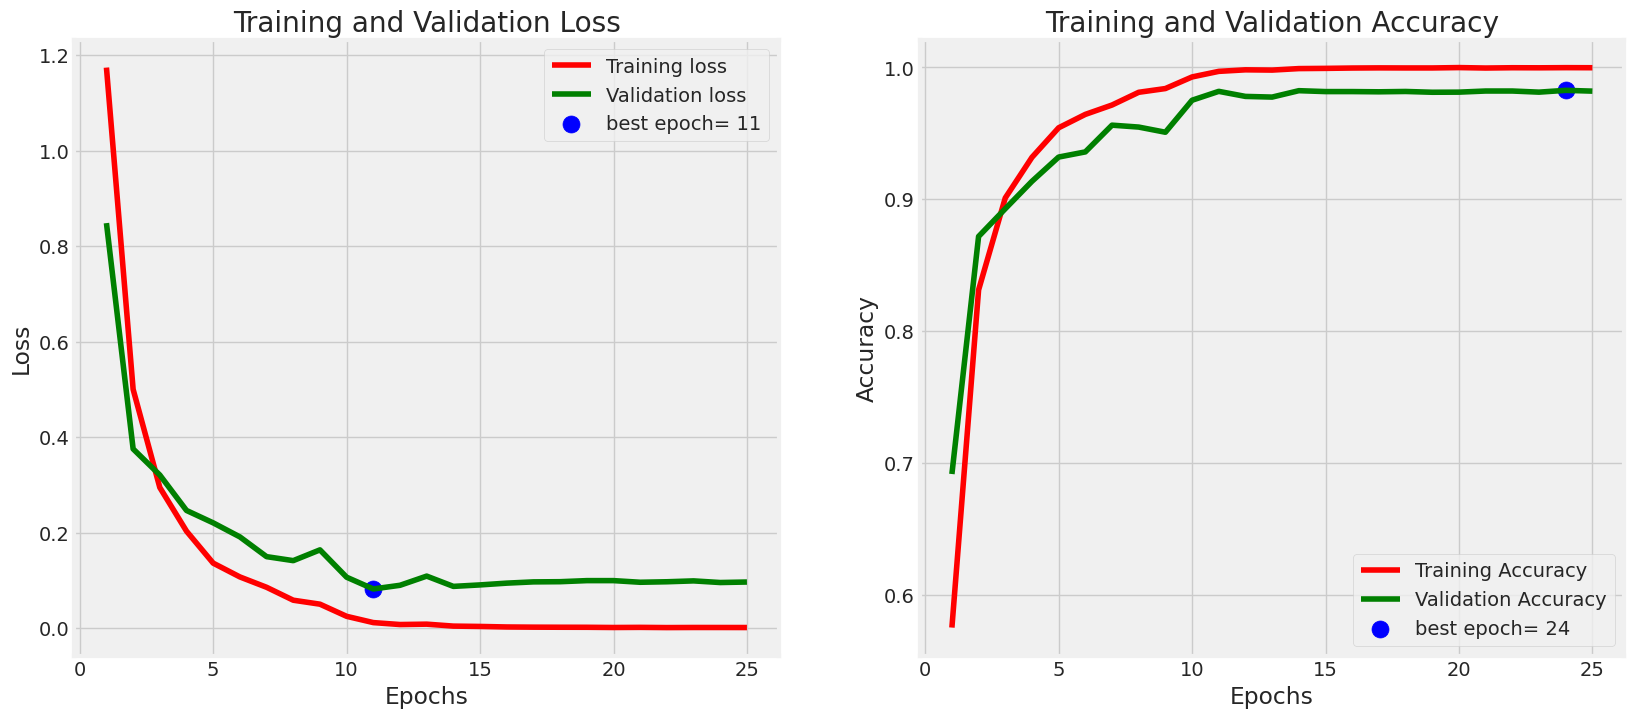

In [26]:
plot_training(history)

# Model Evaluation

In [27]:
train_score = model.evaluate(X_train, y_train, verbose= 1)
test_score = model.evaluate(X_test, y_test, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

367/367 [==============================] - 2s 4ms/step - loss: 0.0696 - accuracy: 0.9859
Train Loss:  0.0014015452470630407
Train Accuracy:  0.999943196773529
--------------------
Test Loss:  0.06964769959449768
Test Accuracy:  0.985938310623169


In [28]:
y_true = np.array(y_test)

y_pred = np.argmax(y_pred , axis=1)
y_true = np.argmax(y_true , axis=1)

In [29]:
from sklearn.metrics import accuracy_score, classification_report

In [30]:
accuracy = accuracy_score(y_true, y_pred)
report = classification_report(y_true, y_pred)

In [31]:
print("Accuracy:", accuracy)
print("Classification Report:\n", report)

Accuracy: 0.9627577978523948
Classification Report:
               precision    recall  f1-score   support

           0       0.80      1.00      0.89      1667
           1       1.00      1.00      1.00      1689
           2       1.00      0.99      0.99      1651
           3       1.00      1.00      1.00      1629
           4       1.00      0.76      0.86      1663
           5       1.00      1.00      1.00      1680
           6       0.99      0.99      0.99      1755

    accuracy                           0.96     11734
   macro avg       0.97      0.96      0.96     11734
weighted avg       0.97      0.96      0.96     11734



In [32]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.80      1.00      0.89      1667
           1       1.00      1.00      1.00      1689
           2       1.00      0.99      0.99      1651
           3       1.00      1.00      1.00      1629
           4       1.00      0.76      0.86      1663
           5       1.00      1.00      1.00      1680
           6       0.99      0.99      0.99      1755

    accuracy                           0.96     11734
   macro avg       0.97      0.96      0.96     11734
weighted avg       0.97      0.96      0.96     11734



**Create classes labels**

In [33]:
classes_labels = []
for key in classes.keys():
    classes_labels.append(key)

print(classes_labels)

[4, 6, 2, 1, 5, 0, 3]


**Confussion Matrix**

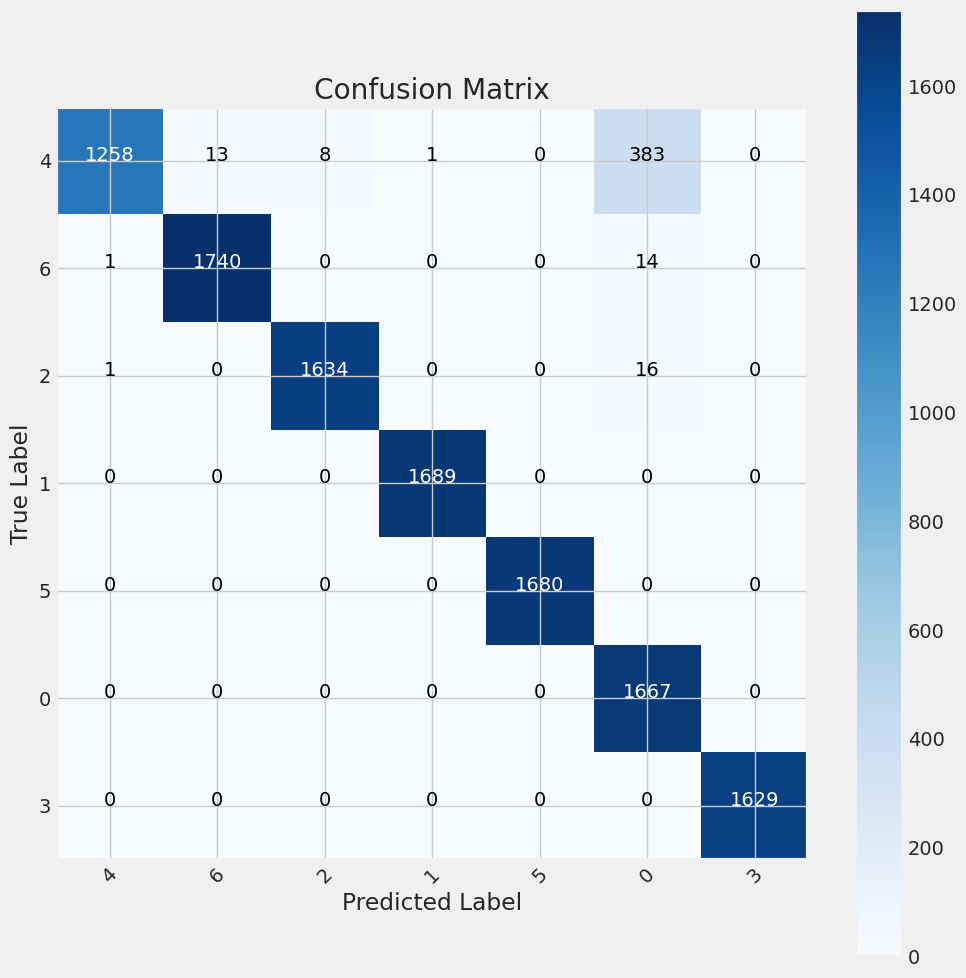

In [34]:
# Confusion matrix
cm = cm = confusion_matrix(y_true, y_pred, labels=classes_labels)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()




In [35]:
# from sklearn.metrics import confusion_matrix, classification_report

# classes = range(7)
    
# # Y_true (true labels) and Y_pred_classes (predicted labels)
# Y_pred = model.predict(X_test)
# Y_pred_classes = np.argmax(Y_pred, axis=1)
# Y_true = np.argmax(y_test, axis=1)

# # Compute the confusion matrix
# confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)

# # Plot the confusion matrix with the new colorscale
# plot_confusion_matrix(confusion_mtx, classes=classes, normalize=False)

# report = classification_report(Y_true, Y_pred_classes)
# print(f"Classification Report for <<CNN RF>> : ")
# print(report)

**Tflite file**

In [36]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

Summary on the non-converted ops:
---------------------------------
 * Accepted dialects: tfl, builtin, func
 * Non-Converted Ops: 31, Total Ops 58, % non-converted = 53.45 %
 * 31 ARITH ops

- arith.constant:   31 occurrences  (f32: 30, i32: 1)



  (f32: 3)
  (f32: 7)
  (f32: 5)
  (f32: 4)
  (f32: 3)
  (f32: 1)
  (f32: 1)


In [37]:
with tf.io.gfile.GFile('model__v1.tflite', 'wb') as f:
  f.write(tflite_model)

In [38]:
import skimage.io 
import pickle

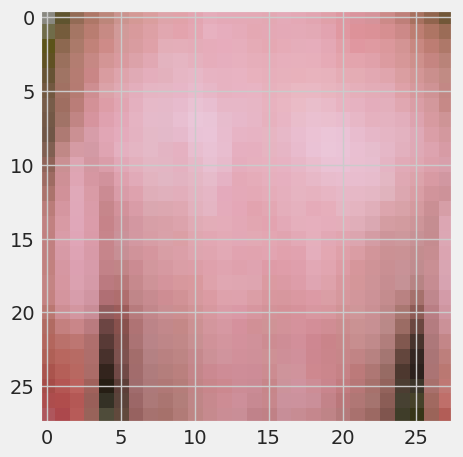

In [39]:
Xi = skimage.io.imread("/kaggle/input/image-predict/0_2.jpg")
Xj = skimage.transform.resize(Xi, (299,299))
Xi = skimage.transform.resize(Xi, (28,28)) 

Xi = (Xi - 0.5)*2 #Inception pre-processing
skimage.io.imshow(Xi/2+0.5) # Show image before inception preprocessing

In [40]:
# cnnrf_loaded = pickle.load(open("model__v1.tflite","rb"))


In [41]:
np.random.seed(222)
preds = model.predict(Xi[np.newaxis,:,:,:])
classes[0] #Top 5 classes

1/1 [==============================] - 0s 208ms/step


('akiec', 'Actinic keratoses and intraepithelial carcinomae')

In [42]:
!pip install lime

In [43]:
!sed -i 's/from scipy.spatial import ConvexHull, QhullError/from scipy.spatial import ConvexHull/g' /opt/conda/lib/python3.10/site-packages/scipy/spatial/__init__.py

In [44]:
from lime import *

In [45]:
from scipy.spatial.qhull import QhullError
from scipy import spatial
spatial.QhullError = QhullError

In [46]:
from lime import lime_image
from skimage.segmentation import mark_boundaries

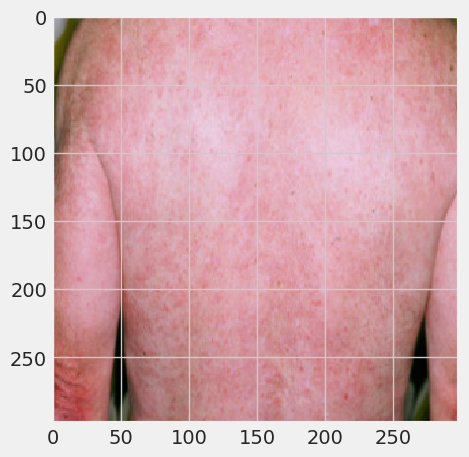

In [47]:

Xj = (Xj - 0.5)*2 #Inception pre-processing
skimage.io.imshow(Xj/2+0.5) # Show image before inception preprocessing

In [48]:
# temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5,
#                                            hide_rest=False)
# plt.subplot (1,1,2)
# plt.imshow(mark_boundaries(temp/ 2 + 0.5, mask))
# plt.title ("LIME Exp")
# plt.show()

  0%|          | 0/1000 [00:00<?, ?it/s]

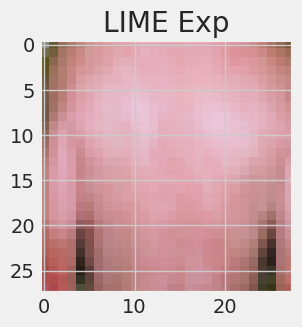

In [49]:
#Xj is incompatible

from lime.wrappers.scikit_image import SegmentationAlgorithm
explainer = lime_image.LimeImageExplainer()
# Assuming you've already created an explainer object and explained an instance
explanation = explainer.explain_instance(Xi, model, top_labels=5, hide_color=0, num_features=100)

temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)

plt.subplot(1, 2, 1)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
plt.title("LIME Exp")
plt.show()


In [50]:
plt.figure(figsize=(299,299))

<Figure size 29900x29900 with 0 Axes>

<Figure size 29900x29900 with 0 Axes>

In [51]:
plt.show()

In [52]:
# #Xj is incompatible

# from lime.wrappers.scikit_image import SegmentationAlgorithm
# explainer = lime_image.LimeImageExplainer()
# # Assuming you've already created an explainer object and explained an instance
# explanation = explainer.explain_instance(Xi, model, top_labels=5, hide_color=0, num_features=100)

# temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
# plt.figure(figsize=(299,299))
# # plt.subplot(1, 2, 1)
# plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
# plt.title("LIME Exp")
# plt.show()


In [53]:
from lime import lime_image
from lime.wrappers.scikit_image import SegmentationAlgorithm
explainer = lime_image.LimeImageExplainer(verbose = False)
segmenter = SegmentationAlgorithm('quickshift', kernel_size=1, max_dist=200, ratio=0.2)

In [54]:
%%time
explanation = explainer.explain_instance(Xi, model, top_labels=5, hide_color=0, num_features=100)


  0%|          | 0/1000 [00:00<?, ?it/s]

CPU times: user 2.26 s, sys: 19.2 ms, total: 2.28 s
Wall time: 2.24 s


In [55]:
from skimage.color import gray2rgb, rgb2gray, label2rgb # since the code wants color images

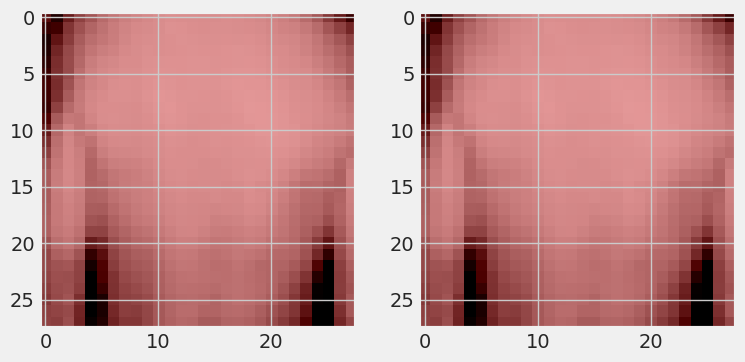

In [56]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)

fig, (ax1, ax2) = plt.subplots(1,2, figsize = (8, 4))
ax1.imshow(label2rgb(mask,temp, bg_label = 0), interpolation = 'nearest')
# ax1.set_title('Positive Regions for {}'.format(Xj))


# temp, mask = explanation.get_image_and_mask(y_test[0], positive_only=False, num_features=10, hide_rest=False, min_weight = 0.01)
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)

ax2.imshow(label2rgb(3-mask,temp, bg_label = 0), interpolation = 'nearest')
# ax2.set_title('Positive/Negative Regions for {}'.format(Xj))

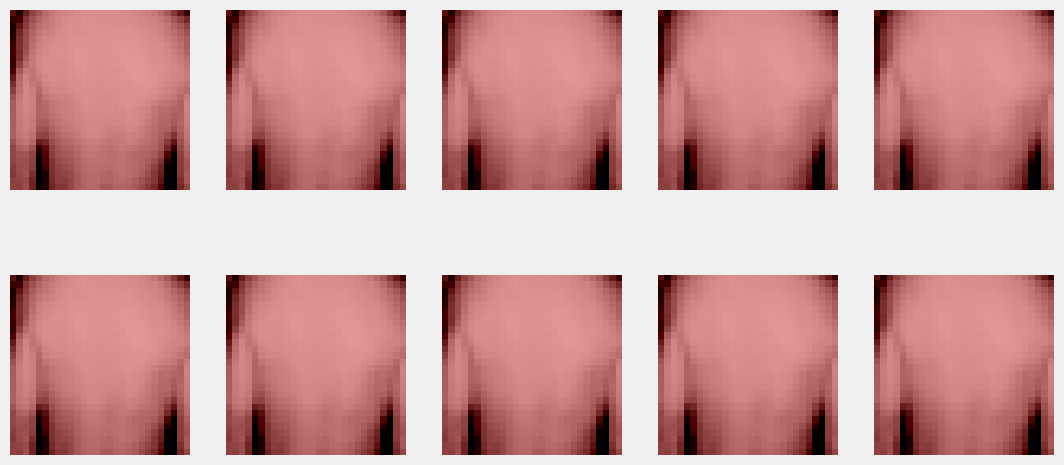

In [57]:
# now show them for each class
fig, m_axs = plt.subplots(2,5, figsize = (12,6))
for i, c_ax in enumerate(m_axs.flatten()):
    temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)

    c_ax.imshow(label2rgb(mask,Xi, bg_label = 0), interpolation = 'nearest')
#     c_ax.set_title('Positive for {}\nActual {}'.format(i, Xi))
    c_ax.axis('off')

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


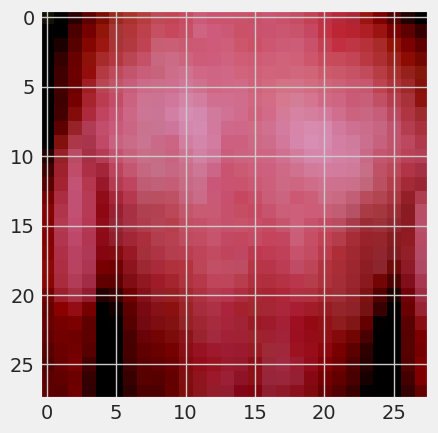

In [58]:
explainer = lime_image.LimeImageExplainer(random_state=42)
explanation = explainer.explain_instance(
         Xi, 
         model.predict
)
plt.imshow(Xi)
image, mask = explanation.get_image_and_mask(
         model.predict(
              Xi.reshape((1,28,28,3))
         ).argmax(axis=1)[0],
         positive_only=True, 
         hide_rest=False)
plt.imshow(mark_boundaries(image, mask))

  0%|          | 0/1000 [00:00<?, ?it/s]

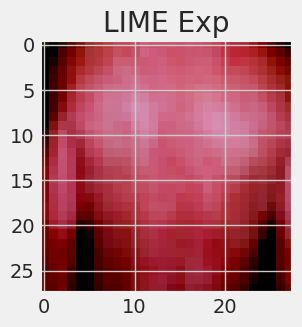

In [59]:
#Xj is incompatible
# expected shape=(None, 28, 28, 3),

from lime.wrappers.scikit_image import SegmentationAlgorithm
explainer = lime_image.LimeImageExplainer()
# Assuming you've already created an explainer object and explained an instance
explanation = explainer.explain_instance(skimage.transform.resize(Xj, (28,28)), model, top_labels=5, hide_color=0, num_features=100)

temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=7, hide_rest=False)

plt.subplot(1, 2, 1)
# plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
plt.title("LIME Exp")
# plt.show()
#skimage.transform.resize(Xj, (28,28))
plt.imshow(mark_boundaries(skimage.transform.resize(Xj, (28,28)), mask))

In [60]:
# IM=skimage.transform.resize(plt.imshow(mark_boundaries(skimage.transform.resize(Xj, (28,28)), mask)),(299,299))

In [61]:
import cv2

In [62]:
#NOT WORKING
# import cv2
# import numpy as np
# import matplotlib.pyplot as plt

# # Load your image as a NumPy array
# #image = cv2.imread('/kaggle/input/singleimage/im1.jpg')
# image=Xi
# # Define the new dimensions for the higher resolution image
# new_width = image.shape[1] * 2  # Double the width
# new_height = image.shape[0] * 2  # Double the height

# # Resize the image using bilinear interpolation
# resized_image = cv2.resize(image, (new_width, new_height), interpolation=cv2.INTER_LINEAR)

# # Convert image to 8-bit unsigned integer
# resized_image = cv2.convertScaleAbs(resized_image)

# # Display the resized image
# plt.imshow(cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB))
# plt.axis('off')  # Hide axis
# plt.show()


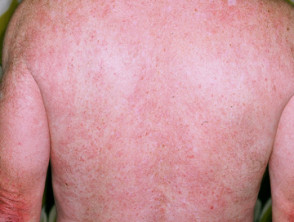

In [63]:
from IPython.display import Image
img_path = '/kaggle/input/image-predict/0_2.jpg'

display(Image(img_path))

In [64]:
# Prepare image
# img_size=(224,224)
img=Xi
# img = Image.open(img1).resize((224,224)) #target_size must agree with what the trained model expects!!

# # Preprocessing the image
# img = image.img_to_array(img)

img = np.expand_dims(img, axis=0)
#RUNNING THIS MULTIPLE TIMES ADDS MULTIPLE DIMS TO ARRAY
# img = img.astype('float32')/255

# # Remove last layer's softmax
# model.layers[-1].activation = None

# # Print what the top predicted class is
# preds = model.predict(img)

In [65]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

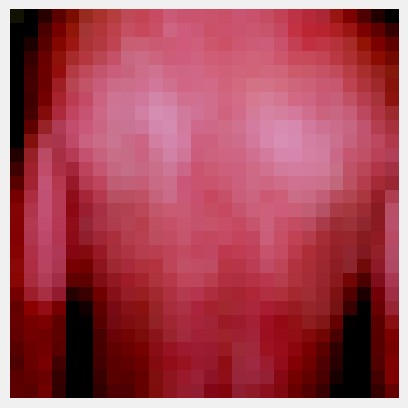

In [66]:


# Remove extra dimensions if present
img = np.squeeze(img)

# Resize the image to match the model input size (28x28)
img = cv2.resize(img, (28, 28))

# Add batch dimension
img = np.expand_dims(img, axis=0)

# Display the resized image
plt.imshow(img[0])
plt.axis('off')
plt.show()

# Now you can pass img to your model


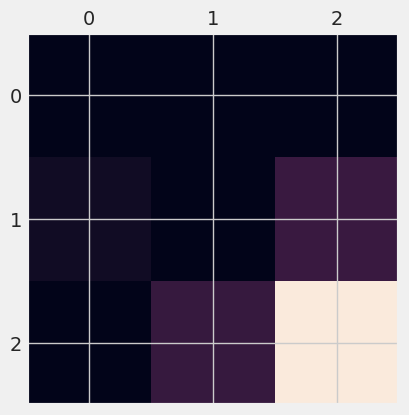

In [67]:
# Generate class activation heatmap
last_conv_layer_name = "conv2d_6"
heatmap = make_gradcam_heatmap(img, model, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.show()

In [68]:
import shap

In [69]:
background = X_test[:100]
e = shap.DeepExplainer(model, background)
e

In [70]:
n_test_images = 10
test_images = X_test[100:100+n_test_images]

num_samples, height, width, channels = test_images.shape
test_images_flattened = test_images.reshape(num_samples, height * width * channels)


In [71]:

test_images_flattened.shape

(10, 2352)

In [72]:
test_images_flattened = np.random.rand(10, 2352)

additional_arrays = np.random.rand(10, 28, 28, 3) 

In [73]:
test_images_flattened_shape = test_images_flattened.shape
additional_arrays_shape = additional_arrays.shape

print("Shape of test_images_flattened:", test_images_flattened_shape)
print("Shape of additional_arrays:", additional_arrays_shape)

Shape of test_images_flattened: (10, 2352)
Shape of additional_arrays: (10, 28, 28, 3)


In [74]:
test_images_reshaped = test_images_flattened.reshape(10, 28, 28, 3)



In [75]:


shap.explainers._deep.deep_tf.op_handlers["AddV2"] = shap.explainers._deep.deep_tf.passthrough #this solves the "shap_ADDV2" problem but another one will appear 
shap.explainers._deep.deep_tf.op_handlers["FusedBatchNormV3"] = shap.explainers._deep.deep_tf.passthrough #this solves the next problem which allows you to run the 




In [76]:
# shap_values = explainer.shap_values(test_images_reshaped)

In [77]:
DeepExplainer= shap.DeepExplainer(model, test_images)
# DeepExplainer. e = shap.DeepExplainer(model, test_images)
DeepExplainer

In [78]:
shap_values = DeepExplainer.shap_values(test_images)

In [79]:
# shap_values

In [80]:
instance_index = 0
shap_values_instance = shap_values[instance_index]



In [81]:
# shap.plots._waterfall.waterfall_legacy(DeepExplainer.expected_value[0], shap_values_instance , max_display=20)

In [82]:
shap_numpy = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in shap_values]
test_numpy = np.swapaxes(np.swapaxes(test_images, 1, -1), 1, 2)

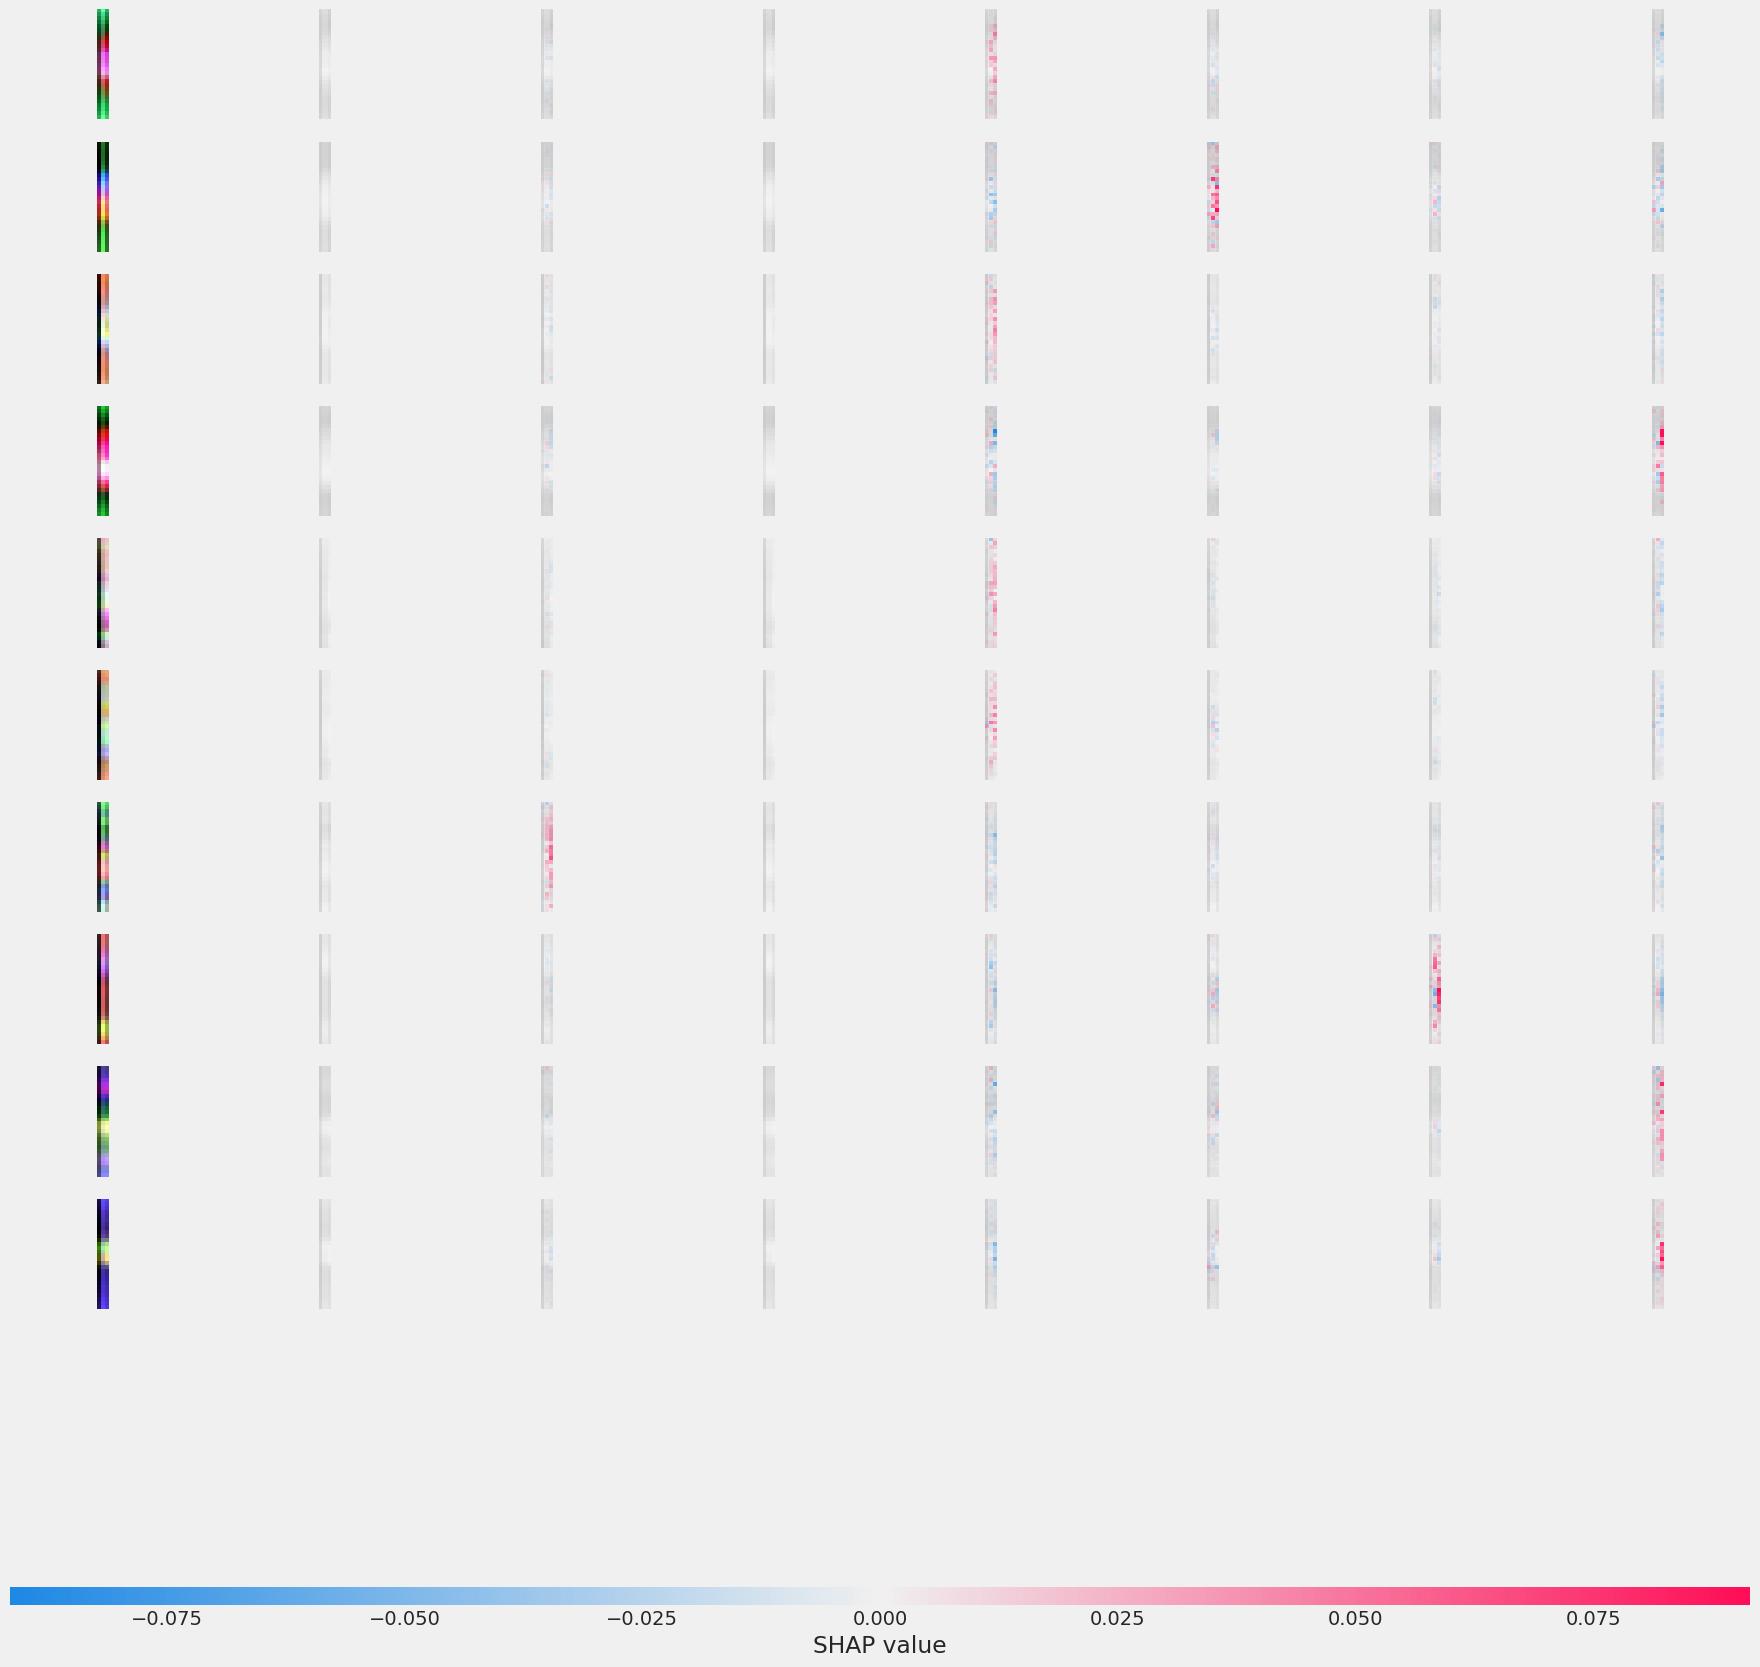

In [83]:
# plot the feature attributions
shap.image_plot(shap_numpy, -test_numpy)